In [1]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [3]:
!conda list

# packages in environment at D:\anaconda\envs\crawler:
#
# Name                    Version                   Build  Channel
absl-py                   0.7.1                    py36_0    conda-forge
astor                     0.7.1                      py_0    conda-forge
backcall                  0.1.0                     <pip>
ca-certificates           2019.3.9             hecc5488_0    conda-forge
certifi                   2019.3.9                 py36_0    conda-forge
colorama                  0.4.1                     <pip>
decorator                 4.4.0                     <pip>
gast                      0.2.2                      py_0    conda-forge
grpcio                    1.16.0          py36hbb4b082_1000    conda-forge
intel-openmp              2019.3                      203  
ipykernel                 5.1.0                     <pip>
ipython                   7.4.0                     <pip>
ipython-genutils          0.2.0                     <pip>
jedi                      0.

In [3]:
import tensorflow
from keras.utils.np_utils import to_categorical

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

Using TensorFlow backend.


Text(0.5, 1.0, 'DXDP')

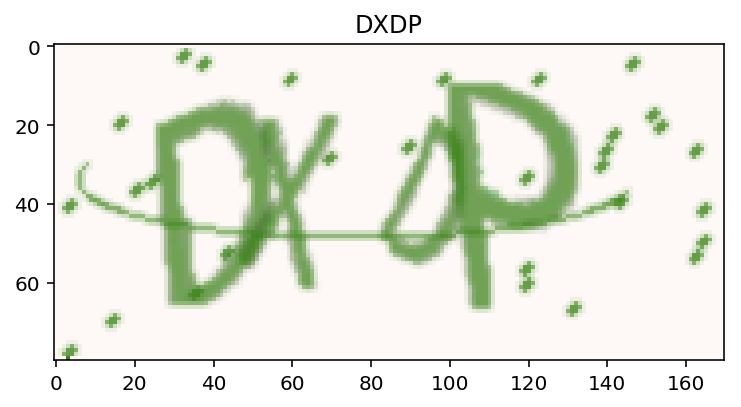

In [4]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

In [6]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = Convolution2D(32*2**i, 3, 3, activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(input=input_tensor, output=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

D:\anaconda\envs\crawler\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  import sys
D:\anaconda\envs\crawler\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
D:\anaconda\envs\crawler\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
D:\anaconda\envs\crawler\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
D:\anaconda\envs\crawler\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  import sys
D:\anaconda\envs\crawler\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras

In [13]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [ ]:
model.fit_generator(gen(), samples_per_epoch=51200, nb_epoch=5,
                    validation_data=gen(), nb_val_samples=1280)

D:\anaconda\envs\crawler\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
D:\anaconda\envs\crawler\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=51200, epochs=5, validation_steps=1280)`
  


Epoch 1/5
 6301/51200 [==>...........................] - ETA: 30:00:35 - loss: 62.6807 - c1_loss: 15.6697 - c2_loss: 15.6681 - c3_loss: 15.6769 - c4_loss: 15.6660 - c1_acc: 0.0278 - c2_acc: 0.0279 - c3_acc: 0.0273 - c4_acc: 0.0280

(-0.5, 169.5, 79.5, -0.5)

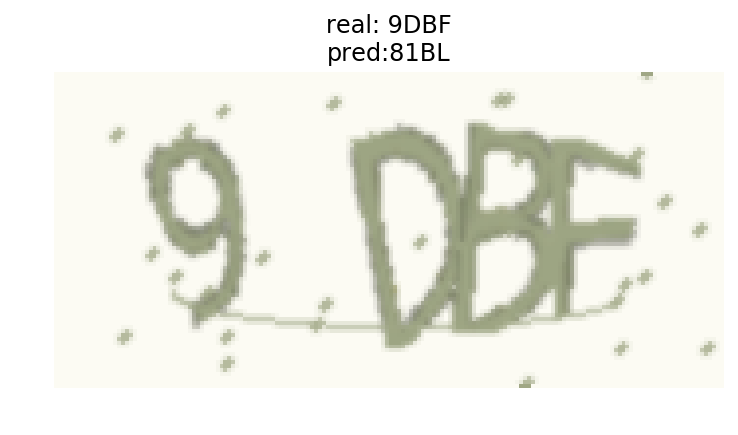

In [14]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

In [ ]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = generator.next()
        y_pred = model.predict(X)
        batch_acc += np.mean(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T))
    return batch_acc / batch_num

evaluate(model)

In [ ]:
model.save('cnn.h5')